In [ ]:
!pip install yfinance sru pandas_ta



In [33]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sru import SRU
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def load_crypto(symbol: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(symbol, start=start, end=end)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df = df.add_prefix(symbol.replace("-USD", "") + "_")
    return df

df = load_crypto("BNB-USD", "2020-01-01", "2025-12-31")
print(df.tail(), df.shape)


scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)
target = scaled_df["BNB_Close"].values

SEQ_LEN = 60
BATCH_SIZE = 32
LR = 1e-3

def create_sequences(data, target, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df.values, target, SEQ_LEN)

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]


X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
y_test_np = y_test.reshape(-1,1)
dummy_cols = df.shape[1]-1
concat_actual = np.concatenate([y_test_np, np.zeros((y_test_np.shape[0], dummy_cols))], axis=1)
actual_inv = scaler.inverse_transform(concat_actual)[:,0]


class SRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(SRUPredictor, self).__init__()
        self.sru = SRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                       dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = x.permute(1,0,2)
        out,_ = self.sru(x)
        return self.fc(out[-1])

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out,_ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(GRUPredictor, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out,_ = self.gru(x)
        return self.fc(out[:, -1, :])

model_configs = {
    "SRU":  {"hidden_size": 32, "num_layers": 2, "dropout": 0.1, "num_epochs": 150},

    "GRU":  {"hidden_size": 128, "num_layers": 3, "dropout": 0.1, "num_epochs": 50},
    "LSTM": {"hidden_size": 64, "num_layers": 2, "dropout": 0.2, "num_epochs": 100},
}

input_size = X.shape[2]
output_size = 1


/tmp/ipython-input-1676461064.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
/usr/local/lib/python3.12/dist-packages/yfinance/scrapers/history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed

Device: cpu
Price         BNB_Open    BNB_High     BNB_Low   BNB_Close  BNB_Volume
Ticker     BNB_BNB-USD BNB_BNB-USD BNB_BNB-USD BNB_BNB-USD BNB_BNB-USD
Date                                                                  
2025-12-26  829.426392  845.717468  823.372925  834.151550  1730790904
2025-12-27  834.151367  844.594360  834.145874  844.554504  1496575663
2025-12-28  844.557556  864.943054  839.592102  858.828796  1855190489
2025-12-29  858.835205  869.985840  846.645325  851.187561  2271142660
2025-12-30  851.190735  862.019836  848.450500  860.553711  2042633098 (2191, 5)


In [ ]:

def train_model_return_preds(ModelClass, model_name):
    print(f"\n===== TRAINING {model_name} =====")
    cfg = model_configs[model_name]
    model = ModelClass(input_size, cfg["hidden_size"], cfg["num_layers"], output_size, cfg["dropout"]).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, cfg["num_epochs"] + 1):
        model.train()
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            preds = preds.view(yb.shape)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_t)
            val_preds = val_preds.view(y_val_t.shape)
            val_loss = criterion(val_preds, y_val_t).item()
        if epoch % 10 == 0 or epoch==1:
            print(f"Epoch {epoch}/{cfg['num_epochs']} - Train Loss: {epoch_loss:.6f} - Val Loss: {val_loss:.6f}")

    # EVALUATION
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test_t).cpu().numpy().reshape(-1,1)

    dummy_cols = df.shape[1]-1
    concat_pred = np.concatenate([preds_test, np.zeros((preds_test.shape[0], dummy_cols))], axis=1)
    preds_inv = scaler.inverse_transform(concat_pred)[:,0]

    return preds_inv
preds_dict = {}
for model_name, ModelClass in zip(["SRU","LSTM","GRU"], [SRUPredictor,LSTMPredictor,GRUPredictor]):
    preds_dict[model_name] = train_model_return_preds(ModelClass, model_name)





===== TRAINING SRU =====


/usr/local/lib/python3.12/dist-packages/sru/ops.py:162: UserWarning: Running SRU on CPU with grad_enabled=True. Are you sure?
  warnings.warn("Running SRU on CPU with grad_enabled=True. Are you sure?")


Epoch 1/150 - Train Loss: 0.048206 - Val Loss: 0.021834
Epoch 10/150 - Train Loss: 0.000659 - Val Loss: 0.000522
Epoch 20/150 - Train Loss: 0.000232 - Val Loss: 0.000368
Epoch 30/150 - Train Loss: 0.000176 - Val Loss: 0.000264
Epoch 40/150 - Train Loss: 0.000151 - Val Loss: 0.000225
Epoch 50/150 - Train Loss: 0.000162 - Val Loss: 0.000251
Epoch 60/150 - Train Loss: 0.000153 - Val Loss: 0.000236
Epoch 70/150 - Train Loss: 0.000148 - Val Loss: 0.000206
Epoch 80/150 - Train Loss: 0.000139 - Val Loss: 0.000227
Epoch 90/150 - Train Loss: 0.000138 - Val Loss: 0.000184
Epoch 100/150 - Train Loss: 0.000147 - Val Loss: 0.000181
Epoch 110/150 - Train Loss: 0.000133 - Val Loss: 0.000214
Epoch 120/150 - Train Loss: 0.000136 - Val Loss: 0.000181
Epoch 130/150 - Train Loss: 0.000141 - Val Loss: 0.000293


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

metrics_dict = {}

for model_name, preds in preds_dict.items():
    mse = mean_squared_error(actual_inv, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_inv, preds)
    mape = np.mean(np.abs((actual_inv - preds) / actual_inv)) * 100

    metrics_dict[model_name] = {
        "MSE": mse,
        "MAE": mae,
        "MAPE (%)": mape,
        "RMSE": rmse,


    }

print("\n===== MODEL PERFORMANCE =====")
for model_name, metrics in metrics_dict.items():
    print(f"{model_name}:")
    print(f"  MSE     : {metrics['MSE']:.4f}")

    print(f"  MAE     : {metrics['MAE']:.4f}")
    print(f"  MAPE (%) : {metrics['MAPE (%)']:.2f}")
    print(f"  RMSE    : {metrics['RMSE']:.4f}")




In [ ]:
plt.figure(figsize=(18,6))

plt.plot(
    train_dates,
    actual_all_inv[:len(X_train)],
    label="Train Actual"
)

plt.plot(
    val_dates,
    actual_all_inv[len(X_train):len(X_train)+len(X_val)],
    label="Validation Actual"
)

plt.plot(
    test_dates,
    actual_all_inv[len(X_train)+len(X_val):],
    label="Test Actual"
)

plt.plot(test_dates, preds_dict["SRU"], linestyle="--", label="SRU Prediction")
plt.plot(test_dates, preds_dict["LSTM"], linestyle="--", label="LSTM Prediction")
plt.plot(test_dates, preds_dict["GRU"], linestyle="--", label="GRU Prediction")

plt.axvline(
    x=val_dates[0],
    linestyle=":",
    linewidth=2,
    label="Train–Validation Split"
)

plt.axvline(
    x=test_dates[0],
    linestyle=":",
    linewidth=2,
    label="Validation–Test Split"
)

plt.title("BNB Price Prediction (Train / Validation / Test)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


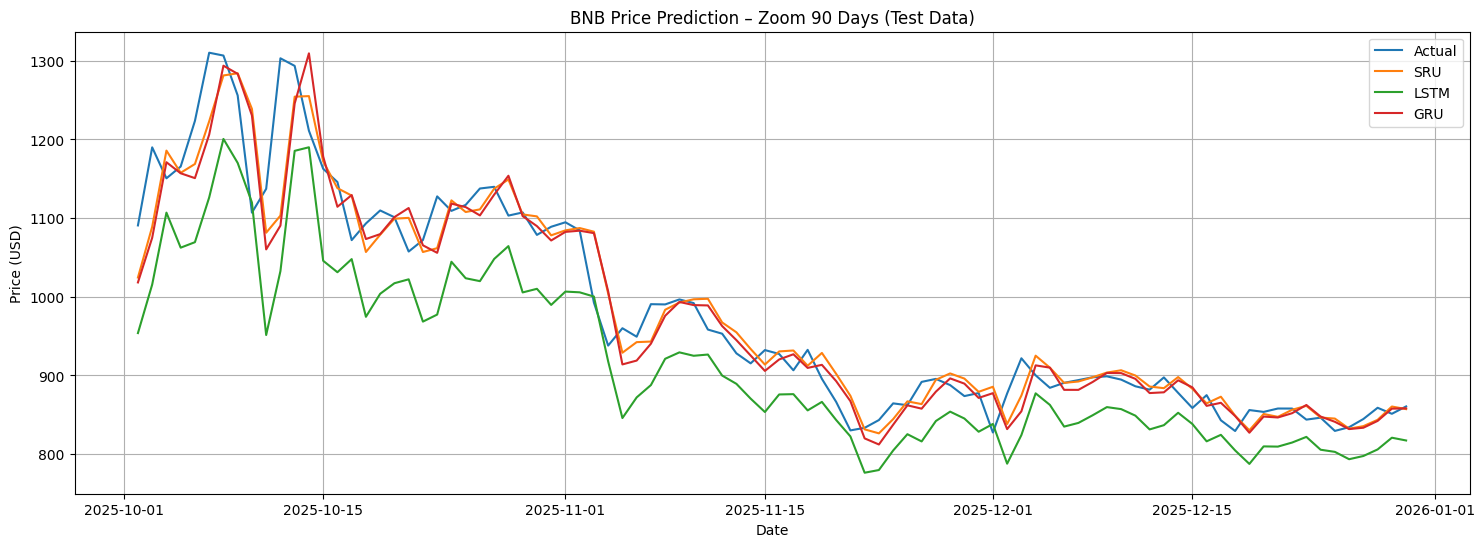

In [ ]:
zoom_days = 90

dates_zoom = test_dates[-zoom_days:]
actual_zoom = actual_all_inv[-zoom_days:]
sru_zoom  = preds_dict["SRU"][-zoom_days:]
lstm_zoom = preds_dict["LSTM"][-zoom_days:]
gru_zoom  = preds_dict["GRU"][-zoom_days:]

plt.figure(figsize=(18,6))

plt.plot(dates_zoom, actual_zoom, label="Actual")
plt.plot(dates_zoom, sru_zoom, label="SRU")
plt.plot(dates_zoom, lstm_zoom, label="LSTM")
plt.plot(dates_zoom, gru_zoom, label="GRU")

plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("BNB Price Prediction – Zoom 90 Days (Test Data)")
plt.legend()
plt.grid(True)
plt.show()


========================================== analisis==========================================-
